In [1]:
!pip install torch torchvision torchsummary numpy matplotlib albumentations tqdm

In [33]:
import math
import numpy
import cv2
import torch
from torchvision import datasets
from torchvision import transforms as tf
from albumentations import *
from albumentations.pytorch import ToTensorV2

class AlbumentationTransformations():

  def __init__(self, means, stdevs):
    """
    Initialize the AlbumentationTransformations class.
    Args:
        means (list): Mean values for normalization (per channel, e.g., [0.5, 0.5, 0.5] for RGB).
        stdevs (list): Standard deviation values for normalization (per channel).
    """
    self.means = numpy.array(means)   # Store the means as a numpy array
    self.stdevs = numpy.array(stdevs) # Store the stds as a numpy array

    patch_size = 32  # Image patch size (not directly used here, maybe for reference)

    # Define a composition of albumentations transformations
    self.album_transforms = Compose([
      HorizontalFlip(p=0.5),   # Randomly flip the image horizontally with 50% probability
      ShiftScaleRotate(p=0.5), # Randomly shift, scale, and rotate the image with 50% probability
      CoarseDropout(           # Randomly mask out a rectangular region in the image
        max_holes=1,           # Max number of regions to drop
        max_height=16,         # Max height of the dropout region
        max_width=16,          # Max width of the dropout region
        min_holes=1,           # Min number of regions to drop
        min_height=16,         # Min height of the dropout region
        min_width=16,          # Min width of the dropout region
        fill_value=self.means, # Fill the dropped-out region with the mean value
        mask_fill_value=None   # Not using a mask fill value
      ),
      Normalize(mean=self.means, std=self.stdevs), # Normalize the image using provided means and stds
      ToTensorV2()             # Convert the augmented image into a PyTorch tensor
    ])

  def __call__(self, img):
      """
      Make the class callable like a function.
      Args:
          img (PIL Image / ndarray): Input image
      Returns:
          Tensor: Transformed image as a PyTorch tensor
      """
      img = numpy.array(img)  # Convert PIL image to numpy array (albumentations works with numpy arrays)
      img = self.album_transforms(image=img)['image']  # Apply albumentations transformations
      return img


In [32]:
"""
Data Loader Module for CIFAR-10 Dataset

This module provides functions to download, preprocess, and create data loaders
for the CIFAR-10 dataset with support for data augmentation and GPU acceleration.
"""

import math
import numpy
import torch
from torchvision import datasets
from torchvision import transforms as tf


def download_CIFAR10_dataset(data_path, train_transforms, test_transforms):
    """
    Downloads and loads the CIFAR-10 dataset with specified transforms.

    Args:
        data_path (str): Path where the dataset will be stored/downloaded
        train_transforms: Transformations to apply to training data
        test_transforms: Transformations to apply to test data

    Returns:
        tuple: (train_dataset, test_dataset) - PyTorch dataset objects
    """
    # Download and load training dataset with specified transforms
    train = datasets.CIFAR10(data_path, train=True, download=True, transform=train_transforms)
    # Download and load test dataset with specified transforms
    test = datasets.CIFAR10(data_path, train=False, download=True, transform=test_transforms)

    return train, test


def generate_transforms(means, stdevs):
    """
    Generates transformation pipelines for training and test data.

    Args:
        means (list): Mean values for normalization [R, G, B]
        stdevs (list): Standard deviation values for normalization [R, G, B]

    Returns:
        tuple: (train_transforms, test_transforms) - Transform objects
    """
    # Use Albumentation for advanced data augmentation on training data
    train_transforms = AlbumentationTransformations(means, stdevs)
    # Simple transforms for test data: convert to tensor and normalize
    test_transforms = tf.Compose([tf.ToTensor(), tf.Normalize(means, stdevs)])

    return train_transforms, test_transforms


def generate_train_test_loader(data_path, means, stdevs, batch_size):
    """
    Creates complete data loaders for training and testing with proper configuration.

    Args:
        data_path (str): Path where the dataset will be stored
        SEED (int): Random seed for reproducibility
        means (list): Mean values for normalization [R, G, B]
        stdevs (list): Standard deviation values for normalization [R, G, B]
        batch_size (int): Number of samples per batch

    Returns:
        tuple: (train_loader, test_loader) - PyTorch DataLoader objects
    """
    # Generate transformation pipelines for train and test data
    train_transforms, test_transforms = generate_transforms(means, stdevs)
    # Download and load the CIFAR-10 dataset
    train, test = download_CIFAR10_dataset(data_path, train_transforms, test_transforms)

    # Check if CUDA (GPU) is available for acceleration
    cuda = torch.cuda.is_available()

    # Set random seed for reproducibility across runs
    torch.manual_seed(1)

    if cuda:
        # Set CUDA seed for GPU operations reproducibility
        torch.cuda.manual_seed(1)

    # Configure dataloader arguments based on CUDA availability
    # CUDA-enabled: Use multiple workers, pin memory for faster GPU transfer
    # CPU-only: Use single worker, smaller batch size
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

    # Create training data loader with configured arguments
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

    # Create test data loader with configured arguments
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

    return train_loader, test_loader


In [9]:
means, stdevs = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
DATA_PATH = './data'
CIFAR10_CLASS_LABELS = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

train_loader, test_loader = generate_train_test_loader(DATA_PATH, means, stdevs, batch_size=128)

100%|██████████| 170M/170M [00:03<00:00, 53.9MB/s]


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import math
import numpy
import glob
import torchvision
import matplotlib.pyplot as plt
import io
import glob
import os
from shutil import move, copy
from os.path import join
from os import listdir, rmdir
import time
import numpy as np
import random
from tqdm import tqdm

def denormalize(tensor, mean, std):
  single_img = False
  if tensor.ndimension() == 3:
    single_img = True
    tensor = tensor[None,:,:,:]

  if not tensor.ndimension() == 4:
    raise TypeError('tensor should be 4D')

  mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
  std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
  ret = tensor.mul(std).add(mean)
  return ret[0] if single_img else ret

def imshow(img,mean, std):
	img = denormalize(img,mean, std)
	npimg = img.numpy()
	plt.imshow(numpy.transpose(npimg, (1, 2, 0)))

def GetCorrectPredCount(pPrediction, pLabels):
    """Counts the number of correct predictions made, i.e. prediction=ground truth

    Args:
        pPrediction (tensor): prediction made by the model
        pLabels (tensor): ground truth

    Returns:
        int: count of correct predictions
    """
    return pPrediction.argmax(dim=1, keepdim=True).eq(pLabels.view_as(pPrediction.argmax(dim=1, keepdim=True))).sum().item()

def train(model, device, train_loader, optimizer, train_acc, train_losses):
    """Trains the model

    Args:
        model (torch.nn.Module): pytorch model
        device (_type_): cuda or cpu
        train_loader (torch.utils.data.DataLoader): data iterator on training data
        optimizer (torch.optim): optimizer function
        train_acc (list): stores accuracy of each batch
        train_losses (list): stores loss of each batch
    """
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = F.nll_loss(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, test_acc, test_losses):
    """_summary_

    Args:
        model (torch.nn.Module): pytorch model
        device (_type_): cuda or cpu
        test_loader (torch.utils.data.DataLoader): data iterator on test data
        test_acc (list): stores accuracy of each batch
        test_losses (list): stores loss of each batch
    """
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-719974792.py:28: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  CoarseDropout(           # Randomly mask out a rectangular region in the image
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 ship  bird   cat   dog  bird truck truck airplane


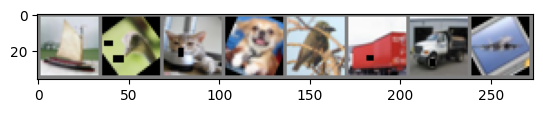

In [37]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define CIFAR10 class labels (copied from cell MQEEvkVJiMV8)
CIFAR10_CLASS_LABELS = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

# show images
imshow(torchvision.utils.make_grid(images[:8]),mean=[0.3713, 0.4202, 0.3838],std =[0.2838, 0.4383, 0.2949])
# print labels
print(' '.join('%5s' % CIFAR10_CLASS_LABELS[labels[j]] for j in range(8)))

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class MyModel(nn.Module):

    def __init__(self, dropout_value=0):
        super(MyModel, self).__init__()
        # Input Block
        self.inpblock = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
        )

        # C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )

        # TRANSITION BLOCK 1 T1
        self.transitionblock1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
        ) # input_size = 32x32x3, output_size = 32x32x16, RF = 3x3

        # CONVOLUTION BLOCK 2 C2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=62, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(62),
            nn.Dropout(dropout_value),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=62, out_channels=72, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(72),
            nn.Dropout(dropout_value),
        )

        # TRANSITION BLOCK 2 T2
        self.transitionblock2 = nn.Sequential(
            nn.Conv2d(in_channels=72, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 3 C3
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            SeparableConv2d(in_channels=64, out_channels=84, kernel_size=1, stride=1, padding=1, dilation=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(84),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=84, out_channels=84, kernel_size=(3, 3), padding=0, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(84),
            nn.Dropout(dropout_value)
        )

        # OUTPUT BLOCK
        self.output = nn.Sequential(
            nn.AvgPool2d(kernel_size=20),
            nn.Conv2d(in_channels=84, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.inpblock(x)
        z = self.convblock1(x)
        z = self.convblock2(z)
        z = self.transitionblock1(z)
        z = F.relu(z)
        z = self.convblock3(z)

        y = self.convblock4(z)
        y = self.convblock5(y)
        y = self.transitionblock2(y)
        y = F.relu(y)
        y = self.convblock6(y)

        y = self.convblock7(y)
        y = self.output(y)
        y = y.view(-1, 10)

        return F.log_softmax(y, dim=-1)



class CIFAR10_C1C2C3C40(nn.Module):
    def __init__(self, num_classes=10, dropout_value=0.05):
        super().__init__()

        # C1: 32ch, downsample with 3x3 s2 (no MaxPool)
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(32, 32, 3, stride=2, padding=1, bias=False),  # downsample-1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
        )

        # C2: 48ch, includes Dilated conv, then stride-2 downsample
        self.c2 = nn.Sequential(
            nn.Conv2d(32, 48, 3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value),

            nn.Conv2d(48, 48, 3, stride=1, padding=2, dilation=2, bias=False),  # Dilated
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value),

            nn.Conv2d(48, 48, 3, stride=2, padding=1, bias=False),  # downsample-2
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value),
        )

        # C3: uses Depthwise Separable conv, then stride-2 downsample
        self.c3 = nn.Sequential(
            SeparableConv2d(48, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),  # Depthwise Separable
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, 3, stride=2, padding=1, bias=False),  # downsample-3
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )

        # C4-0 head: light projection + conv, then GAP and classifier
        self.c40 = nn.Sequential(
            nn.Conv2d(64, 64, 1, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c40(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x, dim=-1)




In [42]:
from torchsummary import summary

# Assuming 'device' is already defined (e.g., "cuda" or "cpu")
# If not, you'll need to define it first:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CIFAR10_C1C2C3C40().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 48, 16, 16]          13,824
             ReLU-14           [-1, 48,

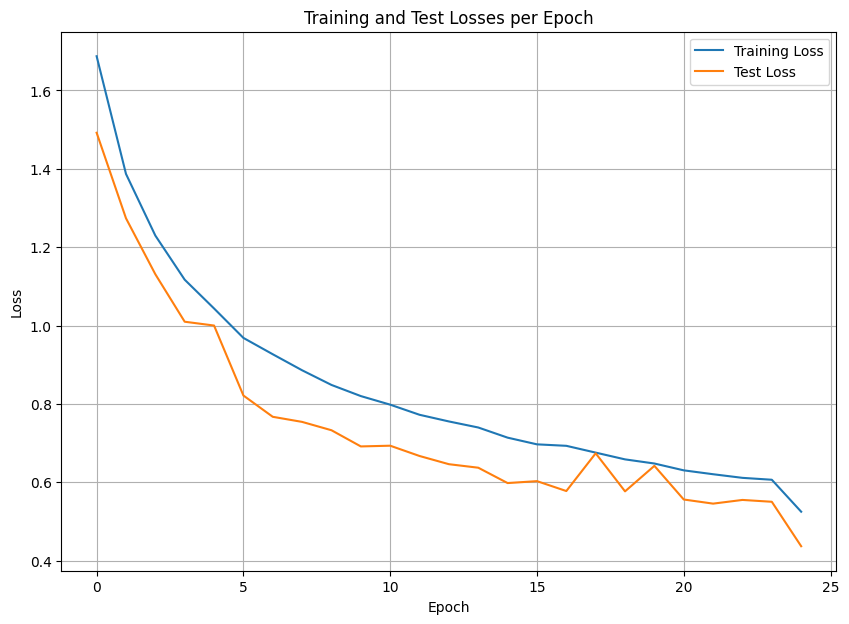

In [43]:
import matplotlib.pyplot as plt

# Plotting the training and test losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses1, label='Training Loss')
plt.plot(test_losses1, label='Test Loss')
plt.title('Training and Test Losses per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
from torchsummary import summary

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

model = CIFAR10_C1C2C3C40().to(device)
summary(model, input_size=(3, 32, 32))

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 48, 16, 16]          13,824
             ReLU-

In [47]:
train_losses1 = []
test_losses1 = []
train_acc1 = []
test_acc1 = []

pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# dropout_value = 0.0483 # Previous value
dropout_value = 0.467 # Typical range for dropout is 0.1 to 0.5
STEP_SIZE = 50

# Define data path, means, stdevs, and batch size
means, stdevs = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
DATA_PATH = './data'
batch_size = 128

# Generate data loaders
train_loader, test_loader = generate_train_test_loader(DATA_PATH, means, stdevs, batch_size)

model1 = CIFAR10_C1C2C3C40(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)
num_epochs = 50

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model1, device, train_loader, optimizer, train_acc1, train_losses1)
  test(model1, device, test_loader, test_acc1, test_losses1)
  if epoch <= STEP_SIZE:
    scheduler.step()

/tmp/ipython-input-719974792.py:28: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  CoarseDropout(           # Randomly mask out a rectangular region in the image


Epoch 1


Train: Loss=1.9146 Batch_id=390 Accuracy=29.39: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s]


Test set: Average loss: 1.5671, Accuracy: 4137/10000 (41.37%)

Epoch 2


Train: Loss=1.8329 Batch_id=390 Accuracy=39.14: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]


Test set: Average loss: 1.4661, Accuracy: 4582/10000 (45.82%)

Epoch 3


Train: Loss=1.5571 Batch_id=390 Accuracy=43.93: 100%|██████████| 391/391 [00:21<00:00, 17.78it/s]


Test set: Average loss: 1.3607, Accuracy: 5018/10000 (50.18%)

Epoch 4


Train: Loss=1.4593 Batch_id=390 Accuracy=46.66: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


Test set: Average loss: 1.3749, Accuracy: 5055/10000 (50.55%)

Epoch 5


Train: Loss=1.3694 Batch_id=390 Accuracy=48.35: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 1.3319, Accuracy: 5165/10000 (51.65%)

Epoch 6


Train: Loss=1.2992 Batch_id=390 Accuracy=49.86: 100%|██████████| 391/391 [00:21<00:00, 18.15it/s]


Test set: Average loss: 1.1733, Accuracy: 5756/10000 (57.56%)

Epoch 7


Train: Loss=1.3665 Batch_id=390 Accuracy=51.20: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s]


Test set: Average loss: 1.1822, Accuracy: 5776/10000 (57.76%)

Epoch 8


Train: Loss=1.9077 Batch_id=390 Accuracy=52.52: 100%|██████████| 391/391 [00:21<00:00, 18.30it/s]


Test set: Average loss: 1.1602, Accuracy: 5837/10000 (58.37%)

Epoch 9


Train: Loss=1.2826 Batch_id=390 Accuracy=53.27: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


Test set: Average loss: 1.1506, Accuracy: 5952/10000 (59.52%)

Epoch 10


Train: Loss=1.5863 Batch_id=390 Accuracy=54.18: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s]


Test set: Average loss: 1.1876, Accuracy: 5806/10000 (58.06%)

Epoch 11


Train: Loss=1.3135 Batch_id=390 Accuracy=54.51: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 1.1335, Accuracy: 5975/10000 (59.75%)

Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Train: Loss=1.2868 Batch_id=390 Accuracy=55.50: 100%|██████████| 391/391 [00:25<00:00, 15.30it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential 

Test set: Average loss: 1.0466, Accuracy: 6329/10000 (63.29%)

Epoch 13


Train: Loss=1.3290 Batch_id=390 Accuracy=55.94: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]


Test set: Average loss: 1.0318, Accuracy: 6311/10000 (63.11%)

Epoch 14


Train: Loss=0.9411 Batch_id=390 Accuracy=56.36: 100%|██████████| 391/391 [00:26<00:00, 14.78it/s]


Test set: Average loss: 1.0115, Accuracy: 6397/10000 (63.97%)

Epoch 15


Train: Loss=1.0572 Batch_id=390 Accuracy=57.30: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s]


Test set: Average loss: 1.0777, Accuracy: 6222/10000 (62.22%)

Epoch 16


Train: Loss=1.0781 Batch_id=390 Accuracy=57.30: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.9776, Accuracy: 6547/10000 (65.47%)

Epoch 17


Train: Loss=1.1528 Batch_id=390 Accuracy=57.89: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]


Test set: Average loss: 0.9653, Accuracy: 6548/10000 (65.48%)

Epoch 18


Train: Loss=1.0133 Batch_id=390 Accuracy=57.96: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Test set: Average loss: 0.9997, Accuracy: 6420/10000 (64.20%)

Epoch 19


Train: Loss=1.1174 Batch_id=390 Accuracy=58.47: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]


Test set: Average loss: 0.9323, Accuracy: 6649/10000 (66.49%)

Epoch 20


Train: Loss=1.4740 Batch_id=390 Accuracy=58.78: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s]


Test set: Average loss: 0.9919, Accuracy: 6593/10000 (65.93%)

Epoch 21


Train: Loss=1.1407 Batch_id=390 Accuracy=59.08: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]


Test set: Average loss: 0.9152, Accuracy: 6719/10000 (67.19%)

Epoch 22


Train: Loss=0.9636 Batch_id=390 Accuracy=59.30: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s]


Test set: Average loss: 0.8817, Accuracy: 6825/10000 (68.25%)

Epoch 23


Train: Loss=1.2773 Batch_id=390 Accuracy=59.81: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Test set: Average loss: 0.9205, Accuracy: 6773/10000 (67.73%)

Epoch 24


Train: Loss=1.0997 Batch_id=390 Accuracy=60.29: 100%|██████████| 391/391 [00:23<00:00, 16.87it/s]


Test set: Average loss: 0.8765, Accuracy: 6890/10000 (68.90%)

Epoch 25


Train: Loss=1.1833 Batch_id=390 Accuracy=60.67: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.9004, Accuracy: 6789/10000 (67.89%)

Epoch 26


Train: Loss=1.0601 Batch_id=390 Accuracy=60.82: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s]


Test set: Average loss: 0.8711, Accuracy: 6892/10000 (68.92%)

Epoch 27


Train: Loss=0.9266 Batch_id=390 Accuracy=60.72: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s]


Test set: Average loss: 0.8681, Accuracy: 6981/10000 (69.81%)

Epoch 28


Train: Loss=1.0857 Batch_id=390 Accuracy=61.27: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s]


Test set: Average loss: 0.8330, Accuracy: 7038/10000 (70.38%)

Epoch 29


Train: Loss=1.0293 Batch_id=390 Accuracy=61.30: 100%|██████████| 391/391 [00:21<00:00, 18.02it/s]


Test set: Average loss: 0.8758, Accuracy: 6931/10000 (69.31%)

Epoch 30


Train: Loss=1.1705 Batch_id=390 Accuracy=61.41: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s]


Test set: Average loss: 0.8203, Accuracy: 7087/10000 (70.87%)

Epoch 31


Train: Loss=1.3303 Batch_id=390 Accuracy=61.80: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]


Test set: Average loss: 0.8113, Accuracy: 7165/10000 (71.65%)

Epoch 32


Train: Loss=0.9795 Batch_id=390 Accuracy=61.92: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s]


Test set: Average loss: 0.8008, Accuracy: 7118/10000 (71.18%)

Epoch 33


Train: Loss=1.0273 Batch_id=390 Accuracy=62.30: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 0.8325, Accuracy: 7049/10000 (70.49%)

Epoch 34


Train: Loss=0.9930 Batch_id=228 Accuracy=62.78:  59%|█████▊    | 229/391 [00:13<00:09, 17.17it/s]


KeyboardInterrupt: 

# Task
Explain what parameters should be changed to achieve 85% accuracy with the current model and data.

## Hyperparameter tuning

### Subtask:
Experiment with different values for learning rate, momentum, and dropout in the optimizer and model definition.


**Reasoning**:
The previous execution failed due to a KeyboardInterrupt. I need to continue the experiment by modifying the learning rate, momentum, and dropout values, and then re-run the training loop for 50 epochs as per the instructions. I will start with a different combination of hyperparameters to explore their effect on accuracy.



Starting training with lr=0.0461, momentum=0.9, dropout=0.4
Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Train: Loss=1.7237 Batch_id=390 Accuracy=31.40: 100%|██████████| 391/391 [00:23<00:00, 16.57it/s]


Test set: Average loss: 1.6237, Accuracy: 4057/10000 (40.57%)

Epoch 2


Train: Loss=1.5644 Batch_id=390 Accuracy=41.61: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]


Test set: Average loss: 1.4047, Accuracy: 4938/10000 (49.38%)

Epoch 3


Train: Loss=1.5764 Batch_id=390 Accuracy=46.29: 100%|██████████| 391/391 [00:22<00:00, 17.58it/s]


Test set: Average loss: 1.2953, Accuracy: 5300/10000 (53.00%)

Epoch 4


Train: Loss=1.4576 Batch_id=390 Accuracy=49.43: 100%|██████████| 391/391 [00:22<00:00, 17.62it/s]


Test set: Average loss: 1.2092, Accuracy: 5639/10000 (56.39%)

Epoch 5


Train: Loss=1.2307 Batch_id=390 Accuracy=51.77: 100%|██████████| 391/391 [00:23<00:00, 17.00it/s]


Test set: Average loss: 1.1657, Accuracy: 5782/10000 (57.82%)

Epoch 6


Train: Loss=1.1493 Batch_id=390 Accuracy=53.39: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s]


Test set: Average loss: 1.0984, Accuracy: 6112/10000 (61.12%)

Epoch 7


Train: Loss=1.3734 Batch_id=390 Accuracy=54.99: 100%|██████████| 391/391 [00:21<00:00, 18.35it/s]


Test set: Average loss: 1.0517, Accuracy: 6182/10000 (61.82%)

Epoch 8


Train: Loss=1.1819 Batch_id=390 Accuracy=56.73: 100%|██████████| 391/391 [00:20<00:00, 18.66it/s]


Test set: Average loss: 1.0500, Accuracy: 6230/10000 (62.30%)

Epoch 9


Train: Loss=1.1244 Batch_id=390 Accuracy=57.46: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s]


Test set: Average loss: 0.9606, Accuracy: 6558/10000 (65.58%)

Epoch 10


Train: Loss=1.1723 Batch_id=390 Accuracy=58.12: 100%|██████████| 391/391 [00:23<00:00, 16.70it/s]


Test set: Average loss: 0.9155, Accuracy: 6719/10000 (67.19%)

Epoch 11


Train: Loss=1.2939 Batch_id=390 Accuracy=59.08: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]


Test set: Average loss: 0.9194, Accuracy: 6678/10000 (66.78%)

Epoch 12


Train: Loss=1.0832 Batch_id=390 Accuracy=60.04: 100%|██████████| 391/391 [00:22<00:00, 17.52it/s]


Test set: Average loss: 0.8859, Accuracy: 6839/10000 (68.39%)

Epoch 13


Train: Loss=1.2825 Batch_id=390 Accuracy=60.59: 100%|██████████| 391/391 [00:22<00:00, 17.64it/s]


Test set: Average loss: 0.8983, Accuracy: 6848/10000 (68.48%)

Epoch 14


Train: Loss=1.3753 Batch_id=390 Accuracy=61.19: 100%|██████████| 391/391 [00:22<00:00, 17.59it/s]


Test set: Average loss: 0.8598, Accuracy: 6959/10000 (69.59%)

Epoch 15


Train: Loss=1.1898 Batch_id=390 Accuracy=62.00: 100%|██████████| 391/391 [00:21<00:00, 18.42it/s]


Test set: Average loss: 0.8509, Accuracy: 6989/10000 (69.89%)

Epoch 16


Train: Loss=1.1252 Batch_id=390 Accuracy=62.31: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s]


Test set: Average loss: 0.8552, Accuracy: 7003/10000 (70.03%)

Epoch 17


Train: Loss=1.1223 Batch_id=390 Accuracy=62.46: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s]


Test set: Average loss: 0.8112, Accuracy: 7114/10000 (71.14%)

Epoch 18


Train: Loss=1.0310 Batch_id=390 Accuracy=63.36: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s]


Test set: Average loss: 0.7786, Accuracy: 7286/10000 (72.86%)

Epoch 19


Train: Loss=1.1584 Batch_id=390 Accuracy=63.62: 100%|██████████| 391/391 [00:22<00:00, 17.62it/s]


Test set: Average loss: 0.7916, Accuracy: 7220/10000 (72.20%)

Epoch 20


Train: Loss=1.1999 Batch_id=390 Accuracy=63.96: 100%|██████████| 391/391 [00:23<00:00, 16.72it/s]


Test set: Average loss: 0.7498, Accuracy: 7399/10000 (73.99%)

Epoch 21


Train: Loss=1.0041 Batch_id=390 Accuracy=64.48: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s]


Test set: Average loss: 0.7650, Accuracy: 7338/10000 (73.38%)

Epoch 22


Train: Loss=1.1769 Batch_id=390 Accuracy=64.69: 100%|██████████| 391/391 [00:21<00:00, 17.99it/s]


Test set: Average loss: 0.7396, Accuracy: 7406/10000 (74.06%)

Epoch 23


Train: Loss=0.9159 Batch_id=390 Accuracy=65.30: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s]


Test set: Average loss: 0.7207, Accuracy: 7458/10000 (74.58%)

Epoch 24


Train: Loss=0.8877 Batch_id=390 Accuracy=65.30: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s]


Test set: Average loss: 0.7070, Accuracy: 7544/10000 (75.44%)

Epoch 25


Train: Loss=1.0601 Batch_id=390 Accuracy=65.57: 100%|██████████| 391/391 [00:22<00:00, 17.57it/s]


Test set: Average loss: 0.7102, Accuracy: 7479/10000 (74.79%)

Epoch 26


Train: Loss=0.9066 Batch_id=390 Accuracy=65.79: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s]


Test set: Average loss: 0.6818, Accuracy: 7654/10000 (76.54%)

Epoch 27


Train: Loss=0.9039 Batch_id=390 Accuracy=66.23: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s]


Test set: Average loss: 0.7197, Accuracy: 7489/10000 (74.89%)

Epoch 28


Train: Loss=1.2718 Batch_id=390 Accuracy=66.61: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s]


Test set: Average loss: 0.6937, Accuracy: 7599/10000 (75.99%)

Epoch 29


Train: Loss=1.0911 Batch_id=390 Accuracy=66.59: 100%|██████████| 391/391 [00:21<00:00, 18.19it/s]


Test set: Average loss: 0.6823, Accuracy: 7650/10000 (76.50%)

Epoch 30


Train: Loss=1.0379 Batch_id=390 Accuracy=66.73: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s]


Test set: Average loss: 0.6611, Accuracy: 7712/10000 (77.12%)

Epoch 31


Train: Loss=1.1513 Batch_id=390 Accuracy=66.98: 100%|██████████| 391/391 [00:21<00:00, 18.31it/s]


Test set: Average loss: 0.6524, Accuracy: 7771/10000 (77.71%)

Epoch 32


Train: Loss=1.0608 Batch_id=390 Accuracy=67.25: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s]


Test set: Average loss: 0.6723, Accuracy: 7682/10000 (76.82%)

Epoch 33


Train: Loss=1.0670 Batch_id=390 Accuracy=67.71: 100%|██████████| 391/391 [00:21<00:00, 17.82it/s]


Test set: Average loss: 0.6590, Accuracy: 7705/10000 (77.05%)

Epoch 34


Train: Loss=0.8721 Batch_id=390 Accuracy=67.66: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s]


Test set: Average loss: 0.6463, Accuracy: 7776/10000 (77.76%)

Epoch 35


Train: Loss=0.7839 Batch_id=390 Accuracy=67.55: 100%|██████████| 391/391 [00:22<00:00, 17.59it/s]


Test set: Average loss: 0.6368, Accuracy: 7844/10000 (78.44%)

Epoch 36


Train: Loss=0.9886 Batch_id=390 Accuracy=67.94: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s]


Test set: Average loss: 0.6320, Accuracy: 7807/10000 (78.07%)

Epoch 37


Train: Loss=0.9077 Batch_id=390 Accuracy=68.09: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]


Test set: Average loss: 0.6575, Accuracy: 7743/10000 (77.43%)

Epoch 38


Train: Loss=1.0515 Batch_id=390 Accuracy=68.47: 100%|██████████| 391/391 [00:22<00:00, 17.51it/s]


Test set: Average loss: 0.6273, Accuracy: 7823/10000 (78.23%)

Epoch 39


Train: Loss=1.0725 Batch_id=390 Accuracy=68.45: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test set: Average loss: 0.6318, Accuracy: 7793/10000 (77.93%)

Epoch 40


Train: Loss=1.0355 Batch_id=390 Accuracy=68.49: 100%|██████████| 391/391 [00:21<00:00, 18.40it/s]


Test set: Average loss: 0.6158, Accuracy: 7870/10000 (78.70%)

Epoch 41


Train: Loss=0.8088 Batch_id=390 Accuracy=68.53: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s]


Test set: Average loss: 0.6176, Accuracy: 7877/10000 (78.77%)

Epoch 42


Train: Loss=0.8362 Batch_id=390 Accuracy=68.79: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]


Test set: Average loss: 0.6127, Accuracy: 7886/10000 (78.86%)

Epoch 43


Train: Loss=0.9204 Batch_id=390 Accuracy=69.16: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s]


Test set: Average loss: 0.6137, Accuracy: 7887/10000 (78.87%)

Epoch 44


Train: Loss=1.2755 Batch_id=390 Accuracy=68.88: 100%|██████████| 391/391 [00:22<00:00, 17.60it/s]


Test set: Average loss: 0.5984, Accuracy: 7935/10000 (79.35%)

Epoch 45


Train: Loss=0.8528 Batch_id=390 Accuracy=68.63: 100%|██████████| 391/391 [00:22<00:00, 17.45it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test set: Average loss: 0.6224, Accuracy: 7806/10000 (78.06%)

Epoch 46


Train: Loss=0.7917 Batch_id=390 Accuracy=68.77: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test set: Average loss: 0.6306, Accuracy: 7829/10000 (78.29%)

Epoch 47


Train: Loss=1.0196 Batch_id=390 Accuracy=69.13: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test set: Average loss: 0.6007, Accuracy: 7935/10000 (79.35%)

Epoch 48


Train: Loss=0.9504 Batch_id=390 Accuracy=69.19: 100%|██████████| 391/391 [00:21<00:00, 18.35it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test set: Average loss: 0.6070, Accuracy: 7912/10000 (79.12%)

Epoch 49


Train: Loss=0.7464 Batch_id=390 Accuracy=69.23: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test set: Average loss: 0.5987, Accuracy: 7921/10000 (79.21%)

Epoch 50


Train: Loss=0.7242 Batch_id=390 Accuracy=69.52: 100%|██████████| 391/391 [00:21<00:00, 18.32it/s]


Test set: Average loss: 0.5872, Accuracy: 7985/10000 (79.85%)



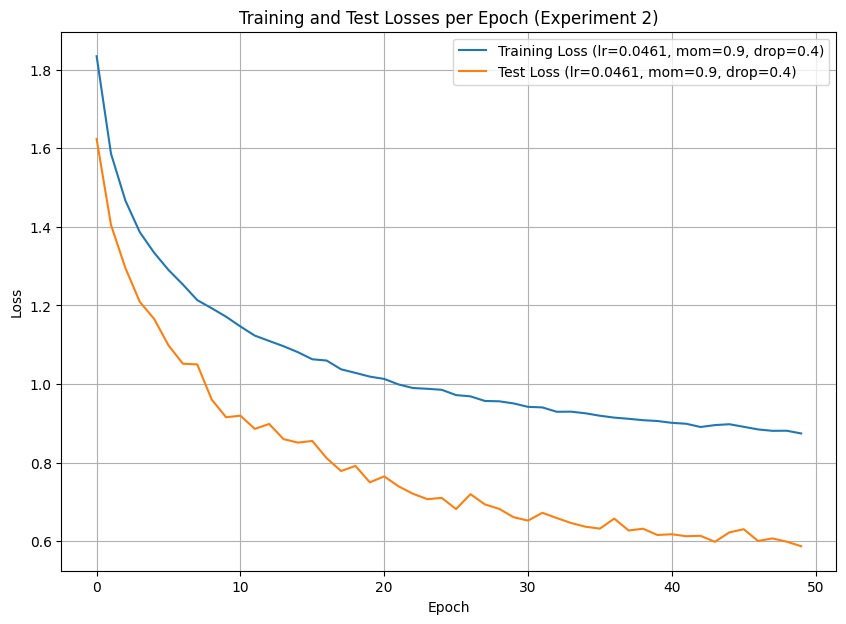

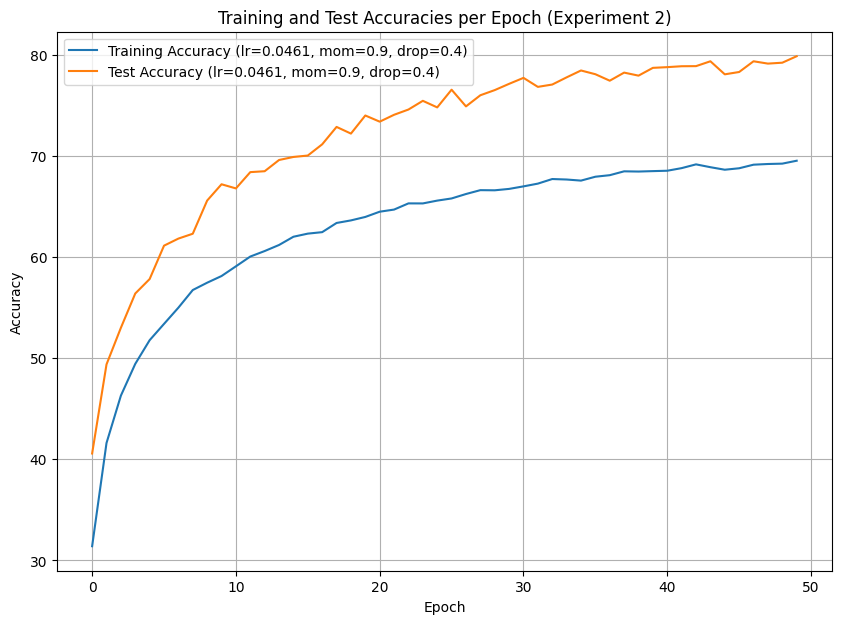

In [49]:
train_losses2 = []
test_losses2 = []
train_acc2 = []
test_acc2 = []

# Experiment 2: Modify hyperparameters
# Learning rate: Reduce slightly from 0.1
# Momentum: Keep at 0.9
# Dropout: Reduce slightly from 0.467

lr_value = 0.0461
momentum_value = 0.9
dropout_value = 0.4

# Define data path, means, stdevs, and batch size (already defined in a previous cell, but redefining for clarity within this experiment block)
# means, stdevs = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
# DATA_PATH = './data'
# batch_size = 128

# Generate data loaders (already generated, no need to regenerate)
# train_loader, test_loader = generate_train_test_loader(DATA_PATH, means, stdevs, batch_size)

# Instantiate the model with the new dropout value
model2 = CIFAR10_C1C2C3C40(dropout_value=dropout_value).to(device)

# Define the optimizer with the new learning rate and momentum
optimizer = optim.SGD(model2.parameters(), lr=lr_value, momentum=momentum_value)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.097)

num_epochs = 50

print(f"Starting training with lr={lr_value}, momentum={momentum_value}, dropout={dropout_value}")

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}')
    train(model2, device, train_loader, optimizer, train_acc2, train_losses2)
    test(model2, device, test_loader, test_acc2, test_losses2)
    if epoch <= STEP_SIZE:
        scheduler.step()

# Plotting the training and test losses for this experiment
plt.figure(figsize=(10, 7))
plt.plot(train_losses2, label=f'Training Loss (lr={lr_value}, mom={momentum_value}, drop={dropout_value})')
plt.plot(test_losses2, label=f'Test Loss (lr={lr_value}, mom={momentum_value}, drop={dropout_value})')
plt.title('Training and Test Losses per Epoch (Experiment 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test accuracies for this experiment
plt.figure(figsize=(10, 7))
plt.plot(train_acc2, label=f'Training Accuracy (lr={lr_value}, mom={momentum_value}, drop={dropout_value})')
plt.plot(test_acc2, label=f'Test Accuracy (lr={lr_value}, mom={momentum_value}, drop={dropout_value})')
plt.title('Training and Test Accuracies per Epoch (Experiment 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()